# Import Library & Set Globals

In [143]:
%load_ext jupyter_black

# base
import os
import sys
import warnings
import logging

logging.basicConfig(level="INFO")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itables.options as opt

opt.interactive = True

warnings.simplefilter("ignore", pd.errors.DtypeWarning)
warnings.simplefilter("ignore", pd.errors.PerformanceWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import decoupler as dc
from liana.method import cellphonedb

# custom
sys.path.append("../..")
from python import *

import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

converter = get_converter()

# R_preload()
%load_ext rpy2.ipython

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%matplotlib inline
study = "paper_processed_FULL"

CORES = 10
DATADIR = "../../../data"
REFDIR = "../../../references"
DOUBLETMETHODS = ["scDblFinder", "DoubletFinder", "doubletdetection", "scrublet"]

# Split Groups

In [ ]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated_all_leiden1"
adata = sc.read_h5ad(
    os.path.join(DATADIR, "processed", study, "py", "3_annotated", f"{annotation}.h5ad")
)

In [ ]:
immune_ids = adata.obs["cell_type"].isin(
    ["Macrophage", "Dendritic Cell", "Mast Cell", "T Cell", "B Cell"]
)
stromal_ids = adata.obs["cell_type"].isin(
    ["Adipocyte", "Fibroblast", "Mesothelial", "Endothelial", "PC/SMC"]
)
adata.obs["pan_cell_type"] = immune_ids.map({True: "Immune", False: "Stromal"})
adata.obs["pan_cell_type"]

In [ ]:
key = "de_immune_v_stromal"
sc.tl.rank_genes_groups(
    adata,
    groupby="pan_cell_type",
    use_raw=False,
    layer="normalized",
    key_added=key,
    method="wilcoxon",
)

... storing 'pan_cell_type' as categorical


categories: Adipocyte, Fibroblast, Mesothelial, etc.
var_group_labels: Immune, Stromal


<Axes: title={'center': 'pan_cell_type'}, xlabel='X_umap1', ylabel='X_umap2'>

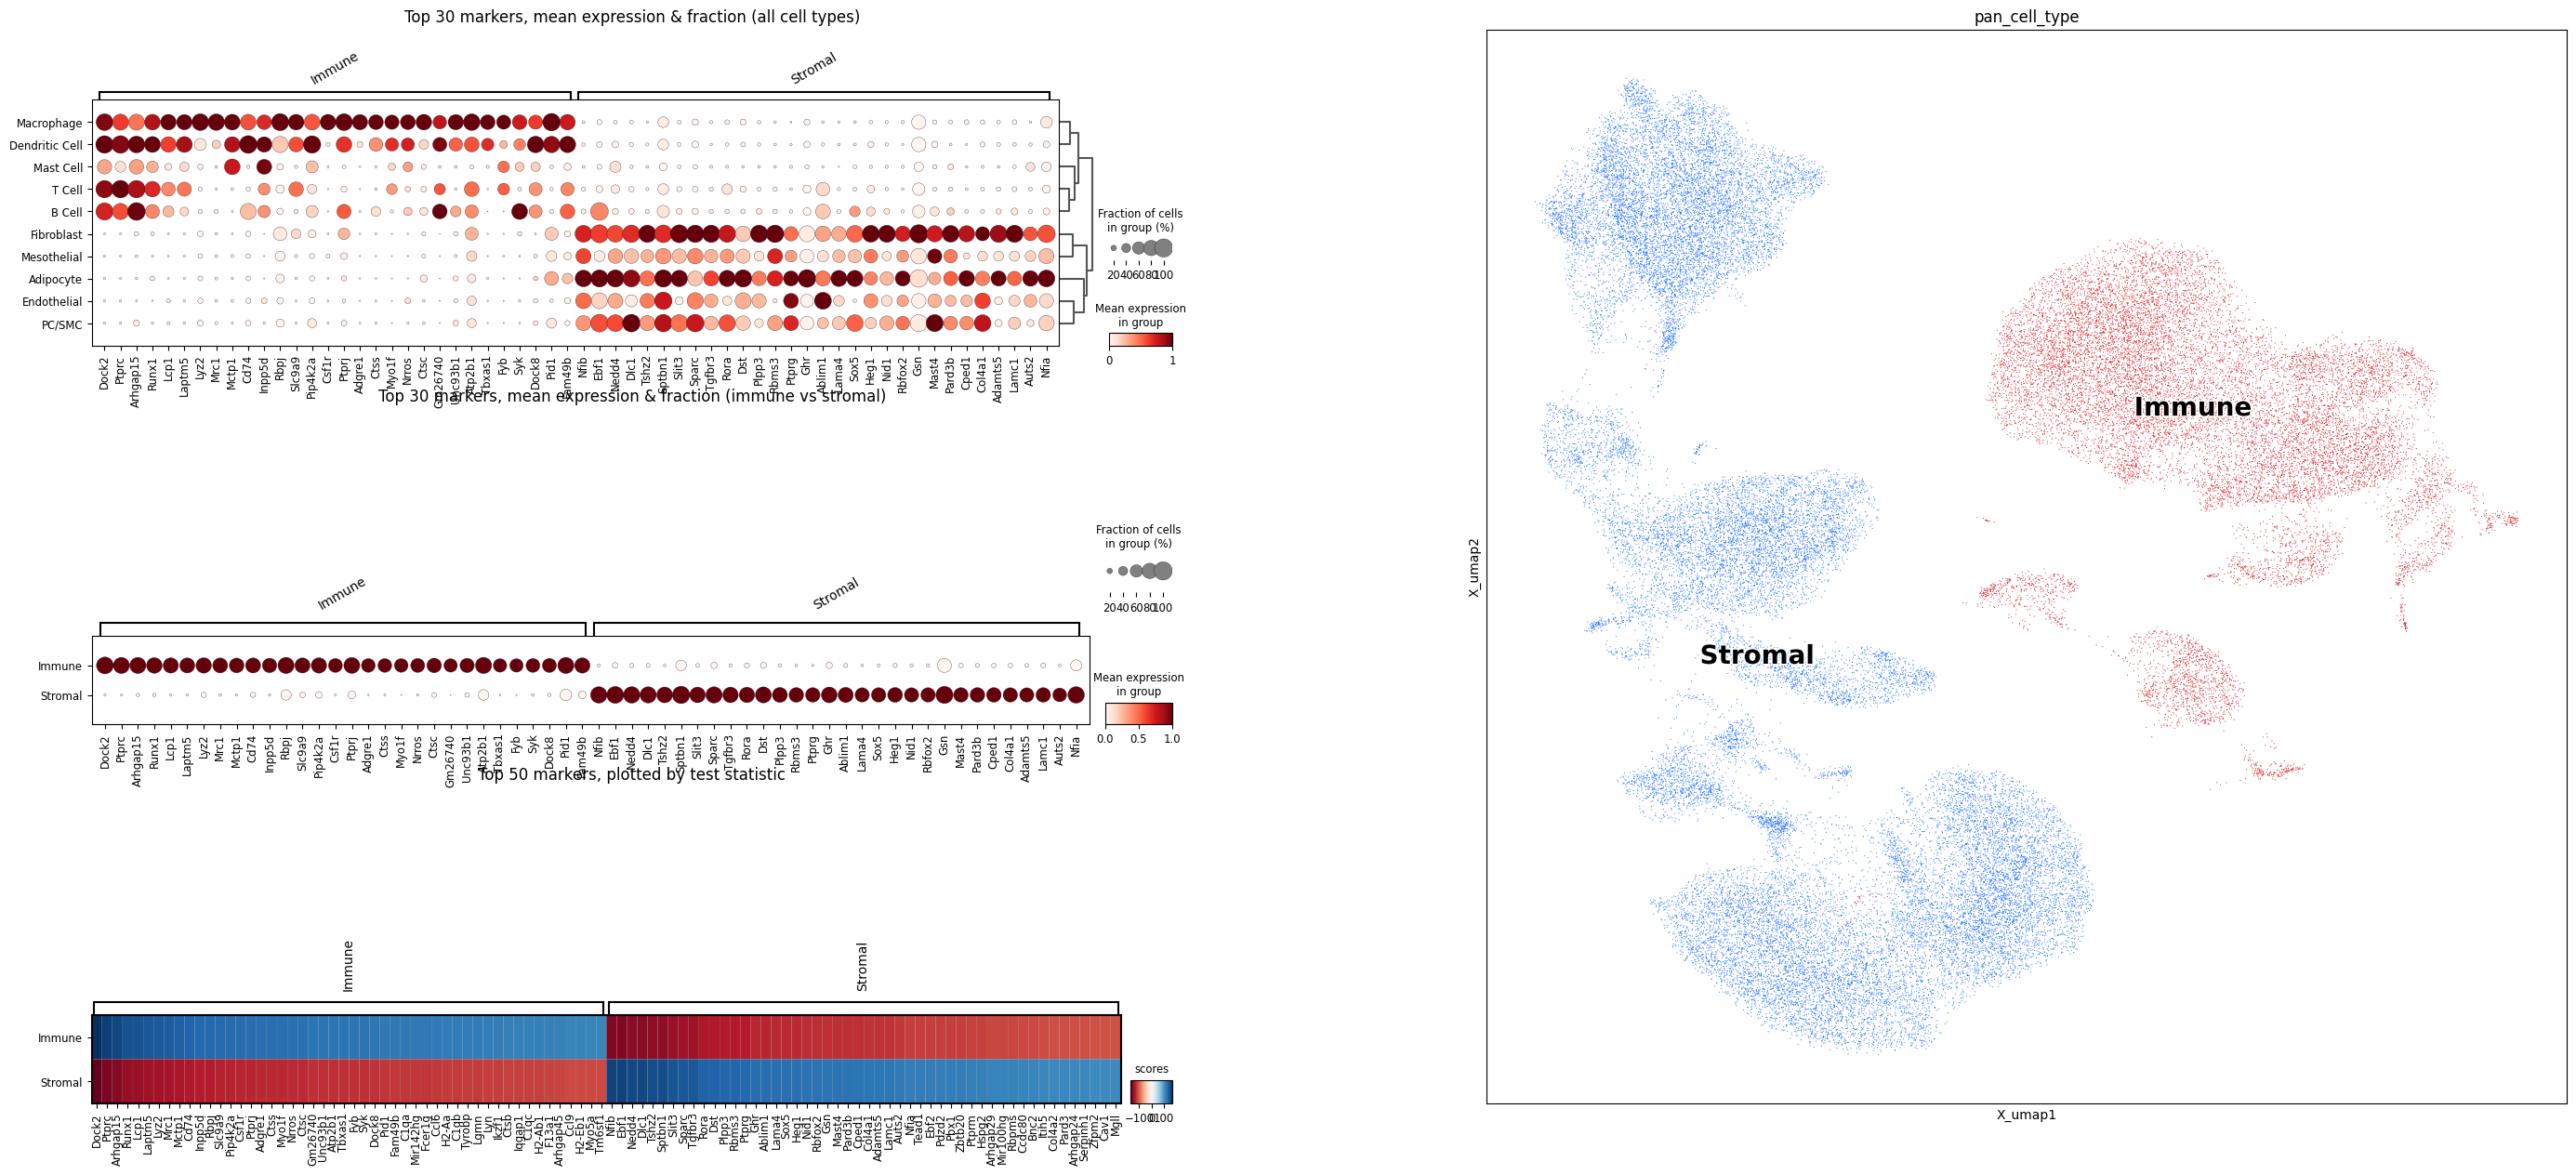

In [50]:
key = "de_immune_v_stromal"
f = plt.figure(figsize=(30, 15))

sf = f.subfigures(1, 2, width_ratios=[1, 1])
axs = sf[0].subplots(3, 1)
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="cell_type",
    key=key,
    standard_scale="var",
    n_genes=30,
    var_group_rotation=30,
    ax=axs[0],
    show=False,
)
axs[0].set_title("Top 30 markers, mean expression & fraction (all cell types)")
sc.pl.rank_genes_groups_dotplot(
    adata,
    groups=None,
    groupby="pan_cell_type",
    key=key,
    standard_scale="var",
    n_genes=30,
    var_group_rotation=30,
    ax=axs[1],
    show=False,
)
axs[1].set_title("Top 30 markers, mean expression & fraction (immune vs stromal)")
sc.pl.rank_genes_groups_matrixplot(
    adata,
    groups=None,
    groupby="pan_cell_type",
    values_to_plot="scores",
    n_genes=50,
    key=key,
    layer="normalized",
    use_raw=False,
    ax=axs[2],
    cmap="RdBu",
    vcenter=0,
    show=False,
)
axs[2].set_title("Top 50 markers, plotted by test statistic")

ax = sf[1].subplots(1, 1)
embedding = "X_umap"
sc.pl.embedding(
    adata,
    basis=embedding,
    color=["pan_cell_type"],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=color_gen(adata.obs["pan_cell_type"]).to_list(),
)

In [120]:
df = sc.get.rank_genes_groups_df(adata, group=None, key="de_immune_v_stromal")
immuneVstromal_markers = pd.concat(
    [
        genes[["group", "names", "scores", "logfoldchanges", "pvals_adj"]].head(500)
        for _, genes in df.groupby("group")
    ]
).reset_index(drop=True)
immuneVstromal_markers

group     names      scores  logfoldchanges  pvals_adj
0     Immune     Dock2  166.284180        6.447921        0.0
1     Immune     Ptprc  156.033035        6.097712        0.0
2     Immune  Arhgap15  151.826508        5.236725        0.0
3     Immune     Runx1  144.876129        5.003940        0.0
4     Immune      Lcp1  143.412567        5.562533        0.0
..       ...       ...         ...             ...        ...
995  Stromal     Adcy5   45.904694        4.391058        0.0
996  Stromal      Aspn   45.874966        3.867854        0.0
997  Stromal     Txlng   45.849247        1.760946        0.0
998  Stromal     Stk39   45.832291        1.350398        0.0
999  Stromal     Smoc2   45.794544        3.776736        0.0

[1000 rows x 5 columns]

# Immune Markers

In [42]:
adata_immune = adata[adata.obs["pan_cell_type"] == "Immune"].copy()
del adata_immune.uns, adata_immune.varm, adata_immune.obsp
sc.pp.filter_cells(adata_immune, min_genes=200)
sc.pp.filter_genes(adata_immune, min_cells=5)
Visualize(adata_immune, "_immune")

Starting UMAP...
Starting LocalMAP...


AnnData object with n_obs × n_vars = 17794 × 19230
    obs: 'Identifier', 'Groups', 'Experiment', 'Condition', 'Sample Type', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'predicted_doublet-scDblFinder', 'doublet_score-scDblFinder', 'predicted_doublet-DoubletFinder', 'doublet_score-DoubletFinder', 'predicted_doublet-doubletdetection', 'doublet_score-doubletdetection', 'predicted_doublet-scrublet', 'doublet_score-scrublet', 'leiden_doublets', 'manual_doublet', 'leiden', 'cell_type', 'pan_cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells'
    uns: 'neighbors', 'UMAP_immune'
    obsm: 'LocalMAP', 'MSigDB-M2-CP_padj_ulm', 'MSigDB-M2-CP_score_ulm', 'MSigDB-M3_padj_ulm', 'MSigDB-M3_score_ulm', 'MSigDB-M5-GO_padj_ulm', 'MSigDB-M5-GO_score_ulm', 'MSigDB-M7_padj_ulm', 'MSigDB-M7

Category Groups has 4 groups!


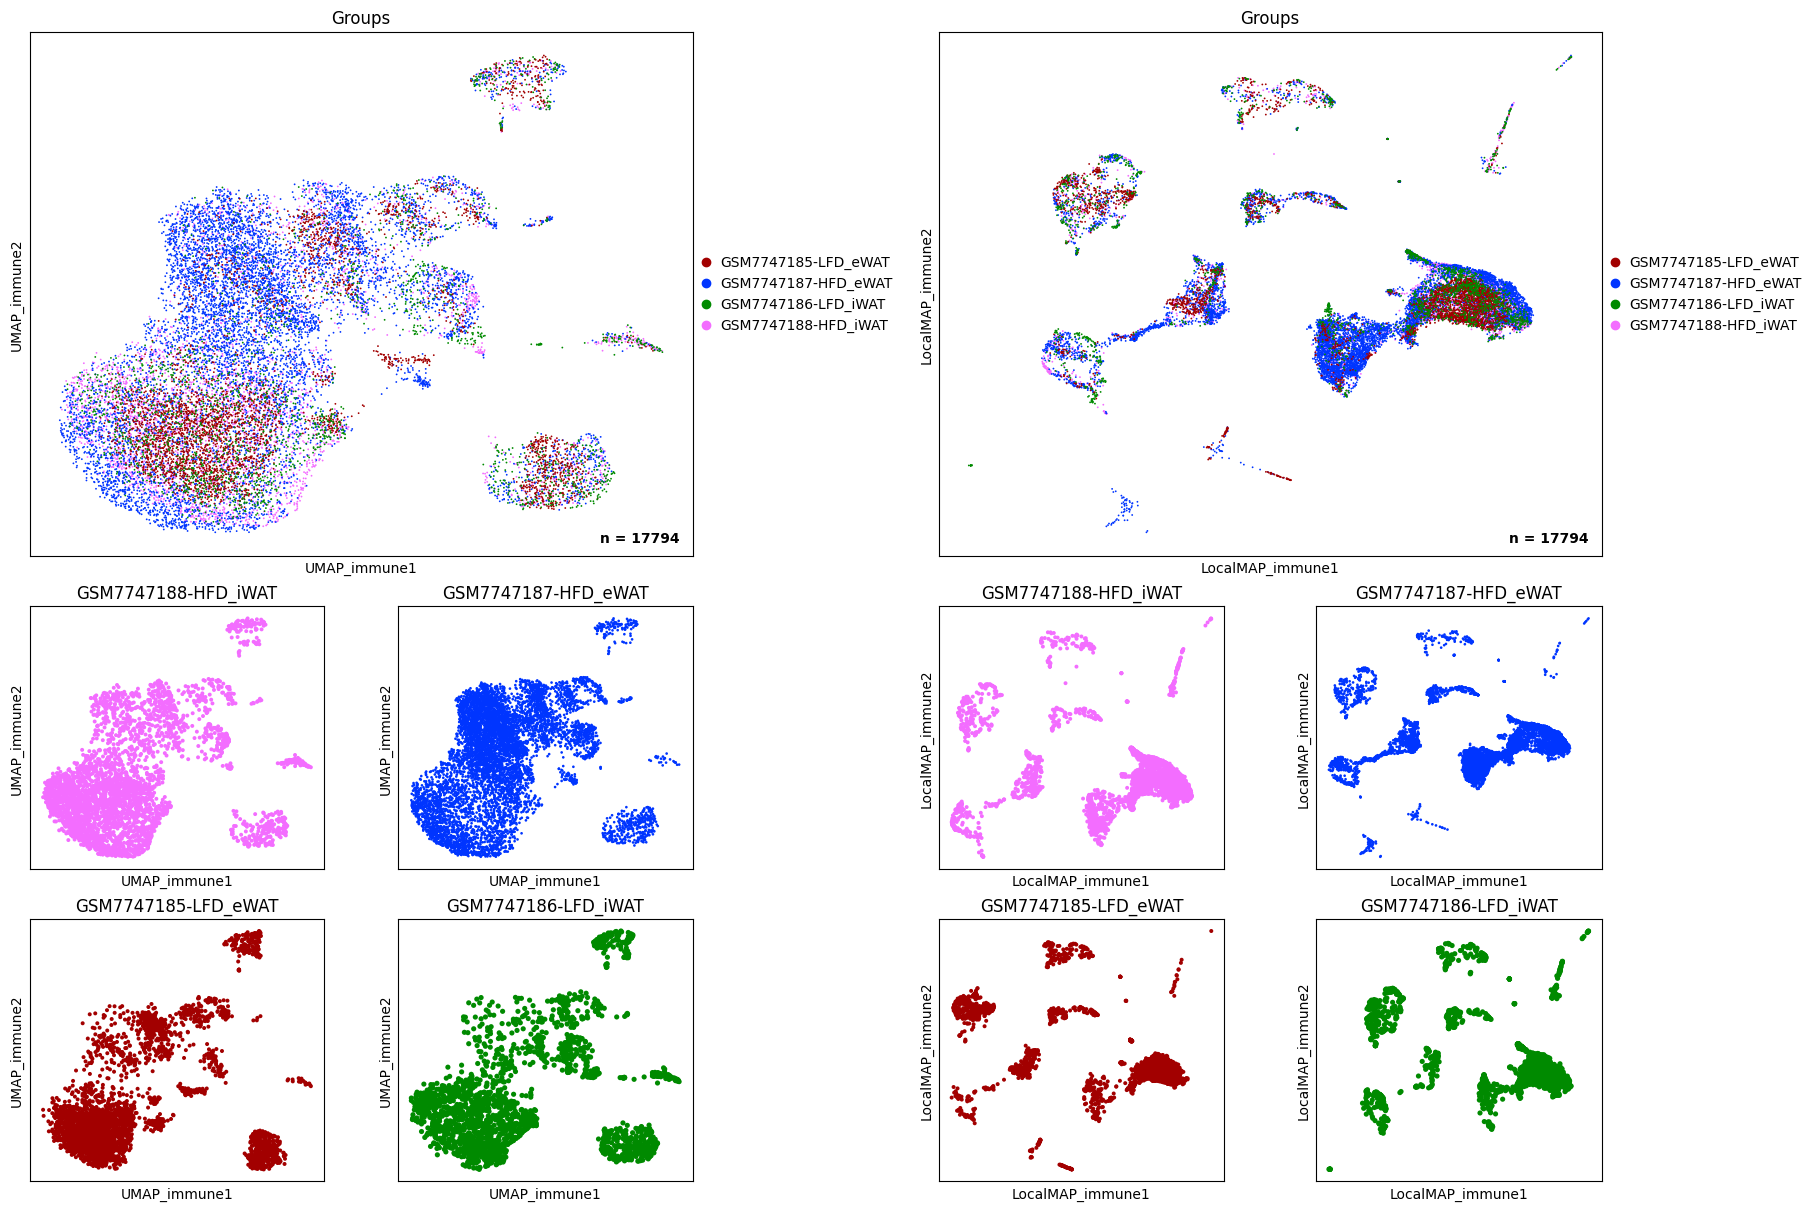

In [51]:
f = plt.figure(figsize=(18, 12), layout="constrained")
check_integration(
    adata_immune,
    "Groups",
    f,
    embeddings=["UMAP_immune", "LocalMAP_immune"],
    nrow=2,
    ncol=2,
)

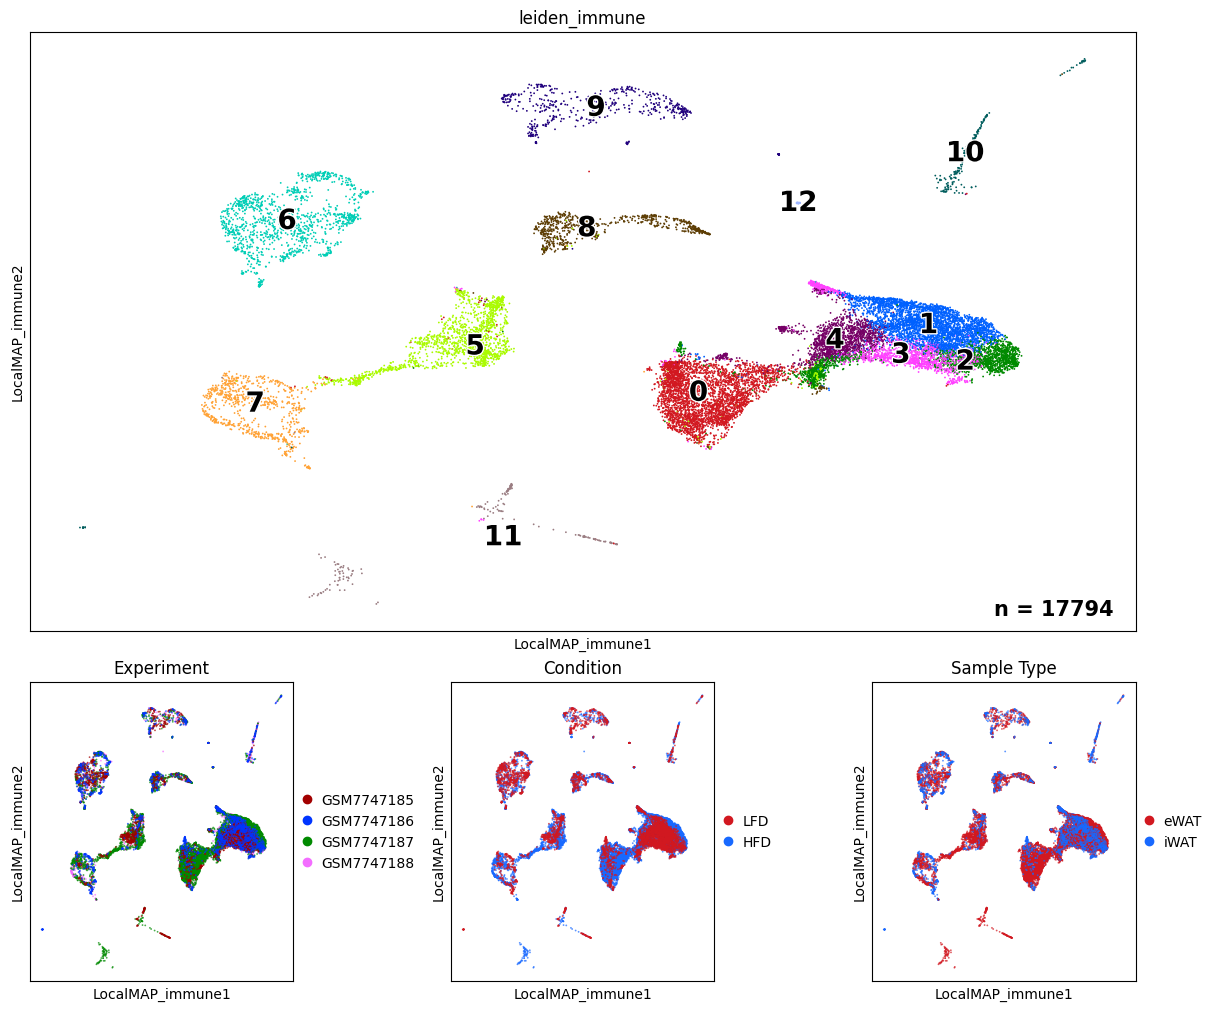

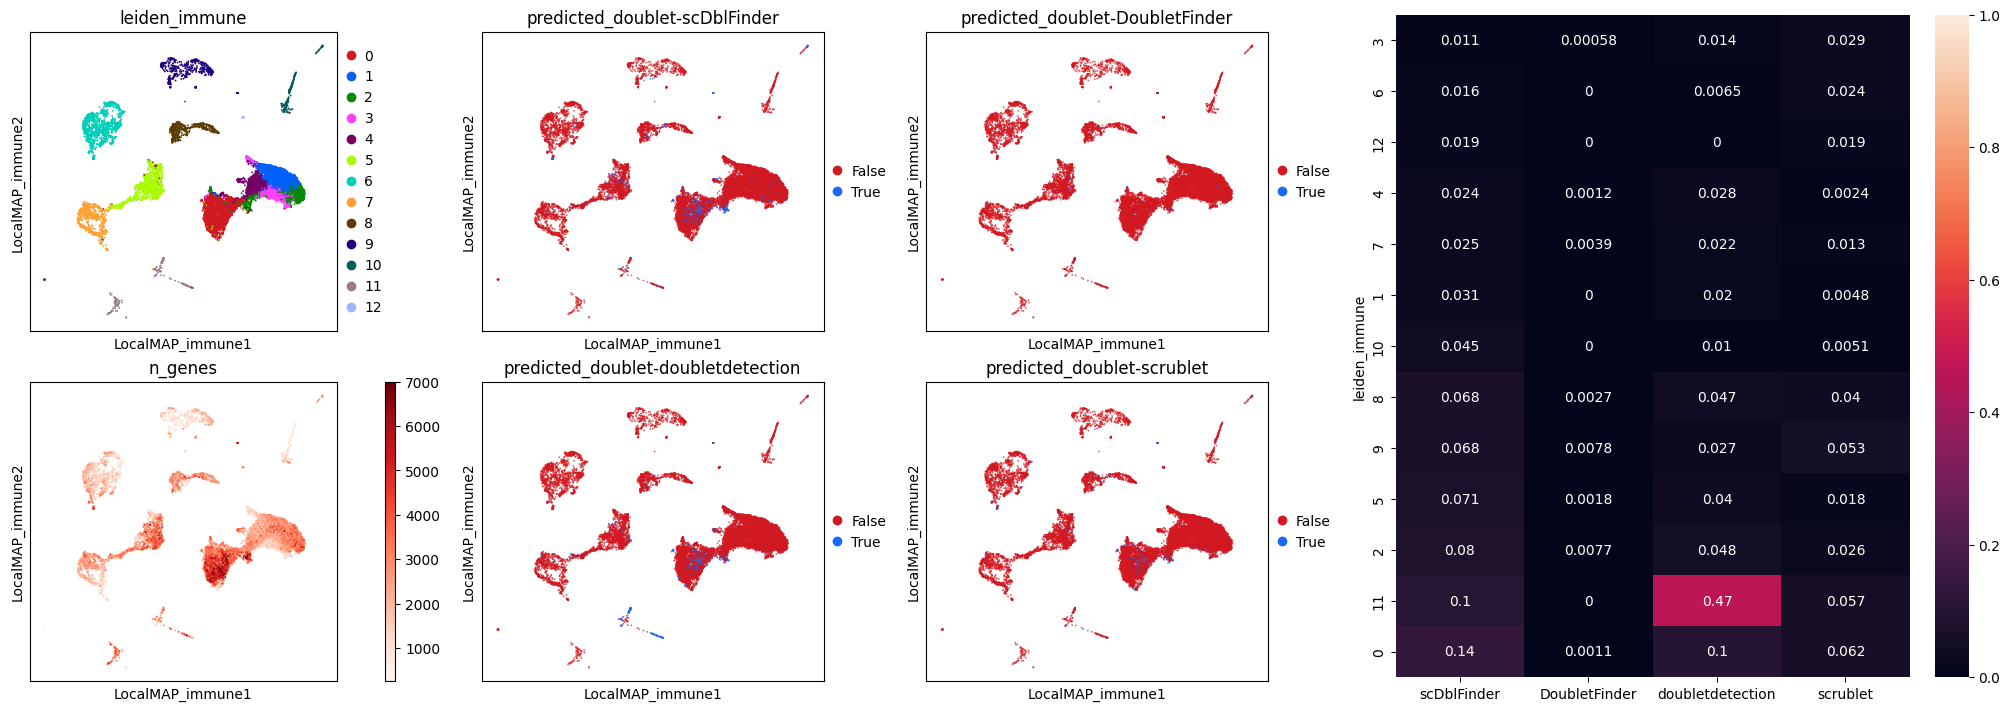

In [ ]:
cluster = False
key = "leiden_immune"

# clsuter
if cluster is True:
    sc.tl.leiden(adata_immune, resolution=0.5, key_added="leiden_immune")

# figure prep
cluster_c = color_gen(adata_immune.obs[key])
f = plt.figure(figsize=(12, 10), layout="constrained")
# sf = f.subfigures(1,2, width_ratios=[2, 1])

# Large LocalMAP plot
axs = f.subplots(3, 3)
gs = axs[0, 0].get_gridspec()
empty_axs(axs)

embedding = "LocalMAP_immune"
ax = f.add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_immune,
    basis=embedding,
    color=[key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=color_gen(adata_immune.obs[key]).to_list(),
)
ax.annotate(
    f"n = {adata_immune.shape[0]}",
    size=15,
    fontweight="bold",
    xy=(0.98, 0.02),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="bottom",
)
ax = f.add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_immune,
    basis=embedding,
    color=["Experiment"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_immune.obs["Experiment"]).to_list(),
)
ax = f.add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_immune,
    basis=embedding,
    color=["Condition"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_immune.obs["Condition"]).to_list(),
)
ax = f.add_subplot(gs[2, 2])
sc.pl.embedding(
    adata_immune,
    basis=embedding,
    color=["Sample Type"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_immune.obs["Sample Type"]).to_list(),
)

checkDoublets(adata_immune, embedding=embedding, cluster_key=key)

leiden_immune      0     1     2     3     4     5     6    7    8    9   10  \
cell_type                                                                      
Macrophage      3576  3524  1947  1731  1677  1644     0  761   27    0    0   
Dendritic Cell     1     0     0     0     0     0     0    0  720    0    0   
Mast Cell          1     0     0     7     1     0     0    0    1    0  198   
T Cell             0     0     0     0     0     0  1237    0    0    0    0   
B Cell             0     0     0     0     0     0     0    0    0  511    0   

leiden_immune    11  12  
cell_type                
Macrophage      176   0  
Dendritic Cell    0  54  
Mast Cell         0   0  
T Cell            0   0  
B Cell            0   0

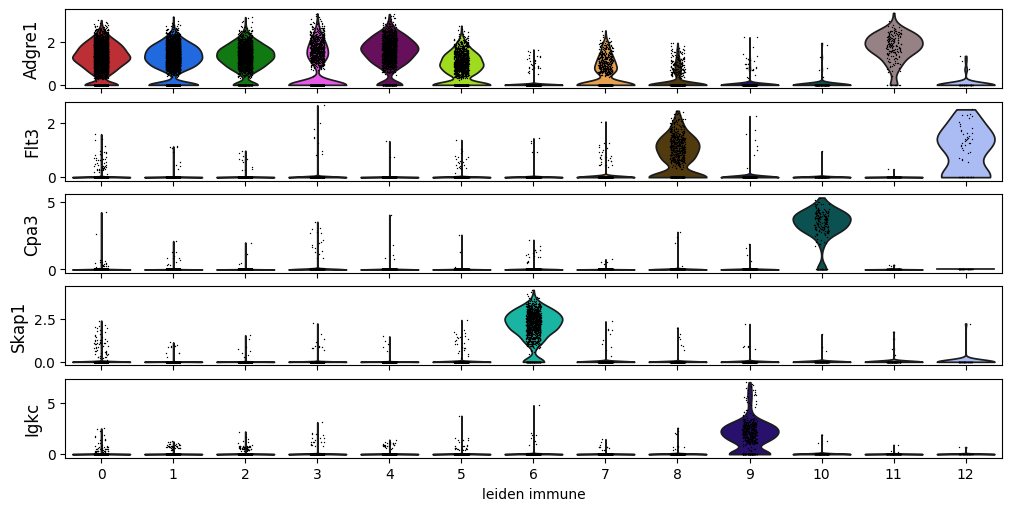

In [ ]:
key = "leiden_immune"

f = plt.figure(figsize=(10, 5), layout="constrained")
markers = ["Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc"]
plot_violinplot(adata_immune, markers, key, f)
pd.crosstab(adata_immune.obs["cell_type"], adata_immune.obs[key])

Text(0.98, 0.02, 'n = 17794')

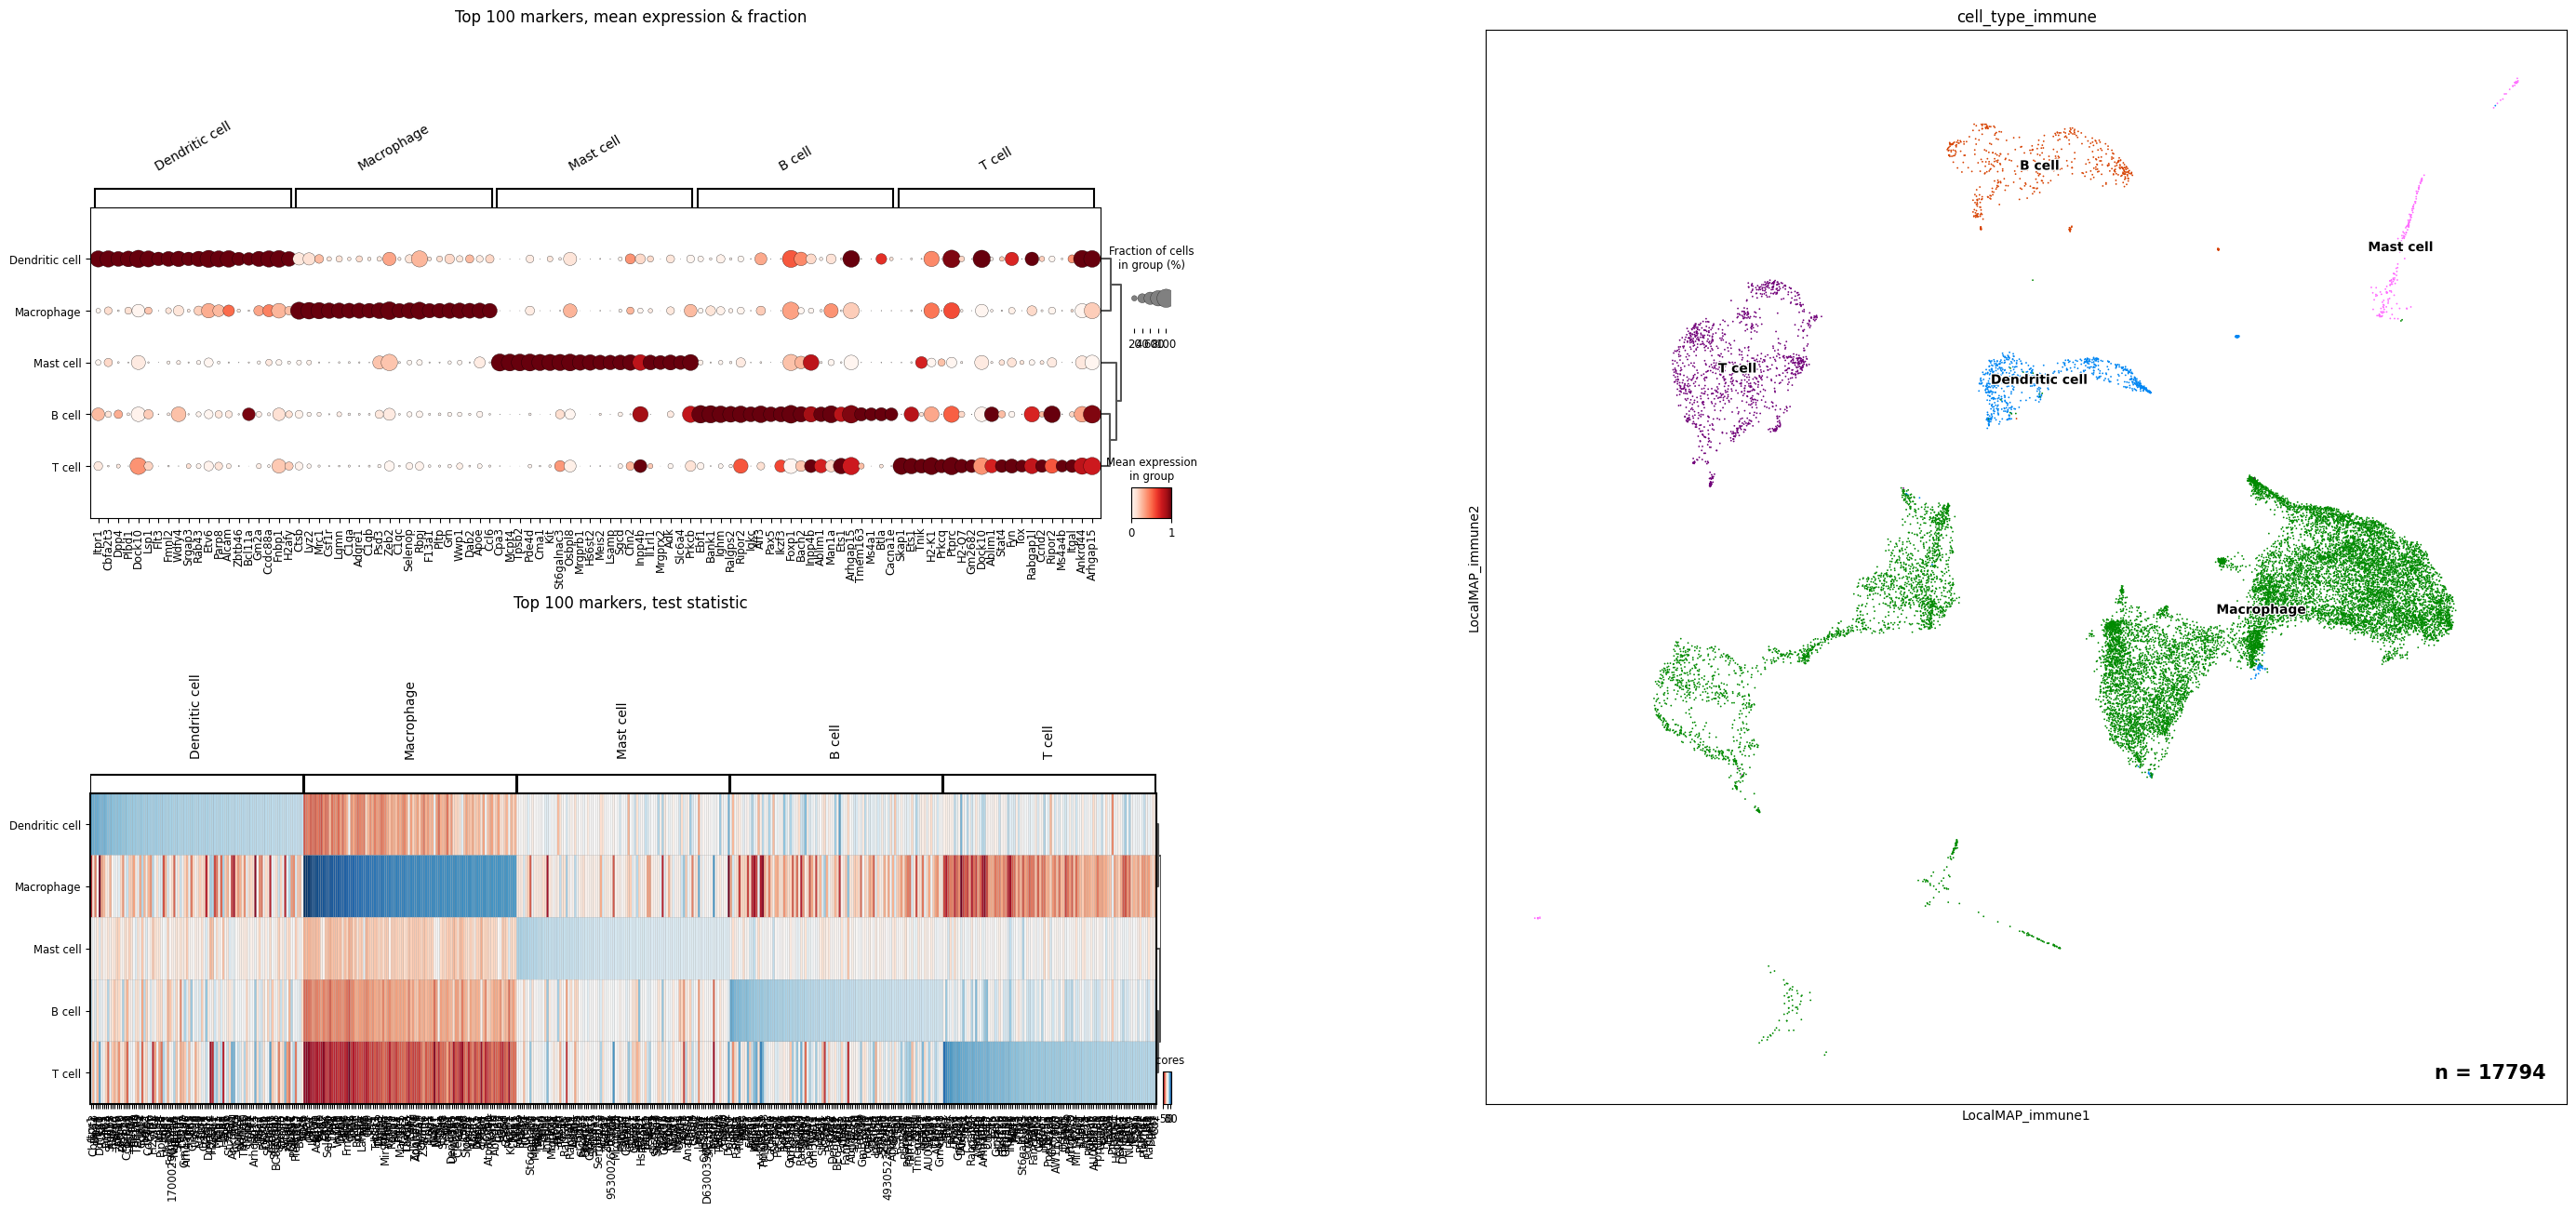

In [ ]:
runDEGs = False
obs_key = "cell_type_immune"
de_key = "de_immune"

adata_immune.obs[obs_key] = (
    adata_immune.obs["leiden_immune"]
    .astype(int)
    .map(
        {
            0: "Macrophage",
            1: "Macrophage",
            2: "Macrophage",
            3: "Macrophage",
            4: "Macrophage",
            5: "Macrophage",
            6: "T cell",
            7: "Macrophage",
            8: "Dendritic cell",
            9: "B cell",
            10: "Mast cell",
            11: "Macrophage",
            12: "Dendritic cell",
        }
    )
    .astype("category")
)

if runDEGs is True:
    sc.tl.rank_genes_groups(
        adata_immune,
        groupby=obs_key,
        use_raw=False,
        layer="normalized",
        key_added=de_key,
        method="wilcoxon",
    )

f = plt.figure(figsize=(30, 15), layout="constrained")

n_degs = 20
sf = f.subfigures(1, 2, width_ratios=[1, 1])
axs = sf[0].subplots(2, 1)
sc.pl.rank_genes_groups_dotplot(
    adata_immune,
    groups=None,
    groupby=obs_key,
    key=de_key,
    standard_scale="var",
    n_genes=n_degs,
    var_group_rotation=30,
    ax=axs[0],
    show=False,
)

n_degs = 100
axs[0].set_title(f"Top {n_degs} markers, mean expression & fraction")
sc.pl.rank_genes_groups_matrixplot(
    adata_immune,
    groups=None,
    groupby=obs_key,
    key=de_key,
    layer="normalized",
    use_raw=False,
    values_to_plot="scores",
    n_genes=n_degs,
    ax=axs[1],
    cmap="RdBu",
    vcenter=0,
    show=False,
)
axs[1].set_title(f"Top {n_degs} markers, test statistic")
axs[1].xaxis.set_visible(False)

ax = sf[1].subplots(1, 1)
sc.pl.embedding(
    adata_immune,
    basis=embedding,
    color=[obs_key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=10,
    palette=color_gen(adata_immune.obs[obs_key]).to_list(),
)
ax.annotate(
    f"n = {adata_immune.shape[0]}",
    size=15,
    fontweight="bold",
    xy=(0.98, 0.02),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="bottom",
)k

In [122]:
df = sc.get.rank_genes_groups_df(adata_immune, group=None, key=de_key)
immune_markers = pd.concat(
    [
        genes[["group", "names", "scores", "logfoldchanges", "pvals_adj"]].head(100)
        for _, genes in df.groupby("group")
    ]
).reset_index(drop=True)
immune_markers

group    names     scores  logfoldchanges      pvals_adj
0    B cell     Ebf1  36.174194        5.980237  2.980632e-282
1    B cell    Bank1  33.949158        4.464967  1.206817e-248
2    B cell     Ighm  32.108265        4.416721  2.166832e-222
3    B cell  Ralgps2  30.800959        4.994893  9.784896e-205
4    B cell   Ripor2  30.310461        3.813111  2.674903e-198
..      ...      ...        ...             ...            ...
495  T cell      Ltb  20.198229        4.562526   4.736104e-89
496  T cell  Rapgef6  20.138430        1.425583   1.575192e-88
497  T cell    Sntb1  20.045153        4.007238   1.026062e-87
498  T cell     Hcst  20.029131        2.959255   1.412184e-87
499  T cell      Cd2  19.966166        3.658452   4.954548e-87

[500 rows x 5 columns]

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-annotated_immune_leiden0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
os.makedirs(savedir, exist_ok=True)
adata_immune.write(os.path.join(savedir, f"{annotation}.h5ad"))

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-annotated_immune_leiden0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
adata_immune = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

# Stromal Markers

In [132]:
adata_stromal = adata[adata.obs["pan_cell_type"] == "Stromal"].copy()
del adata_stromal.uns, adata_stromal.varm, adata_stromal.obsp
sc.pp.filter_cells(adata_stromal, min_genes=200)
sc.pp.filter_genes(adata_stromal, min_cells=5)
Visualize(adata_stromal, "_stromal")

Starting UMAP...
Starting LocalMAP...


AnnData object with n_obs × n_vars = 34349 × 20728
    obs: 'Identifier', 'Groups', 'Experiment', 'Condition', 'Sample Type', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'predicted_doublet-scDblFinder', 'doublet_score-scDblFinder', 'predicted_doublet-DoubletFinder', 'doublet_score-DoubletFinder', 'predicted_doublet-doubletdetection', 'doublet_score-doubletdetection', 'predicted_doublet-scrublet', 'doublet_score-scrublet', 'leiden_doublets', 'manual_doublet', 'leiden', 'cell_type', 'pan_cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells'
    uns: 'neighbors', 'UMAP_stromal'
    obsm: 'LocalMAP', 'MSigDB-M2-CP_padj_ulm', 'MSigDB-M2-CP_score_ulm', 'MSigDB-M3_padj_ulm', 'MSigDB-M3_score_ulm', 'MSigDB-M5-GO_padj_ulm', 'MSigDB-M5-GO_score_ulm', 'MSigDB-M7_padj_ulm', 'MSigDB-M

Category Groups has 4 groups!


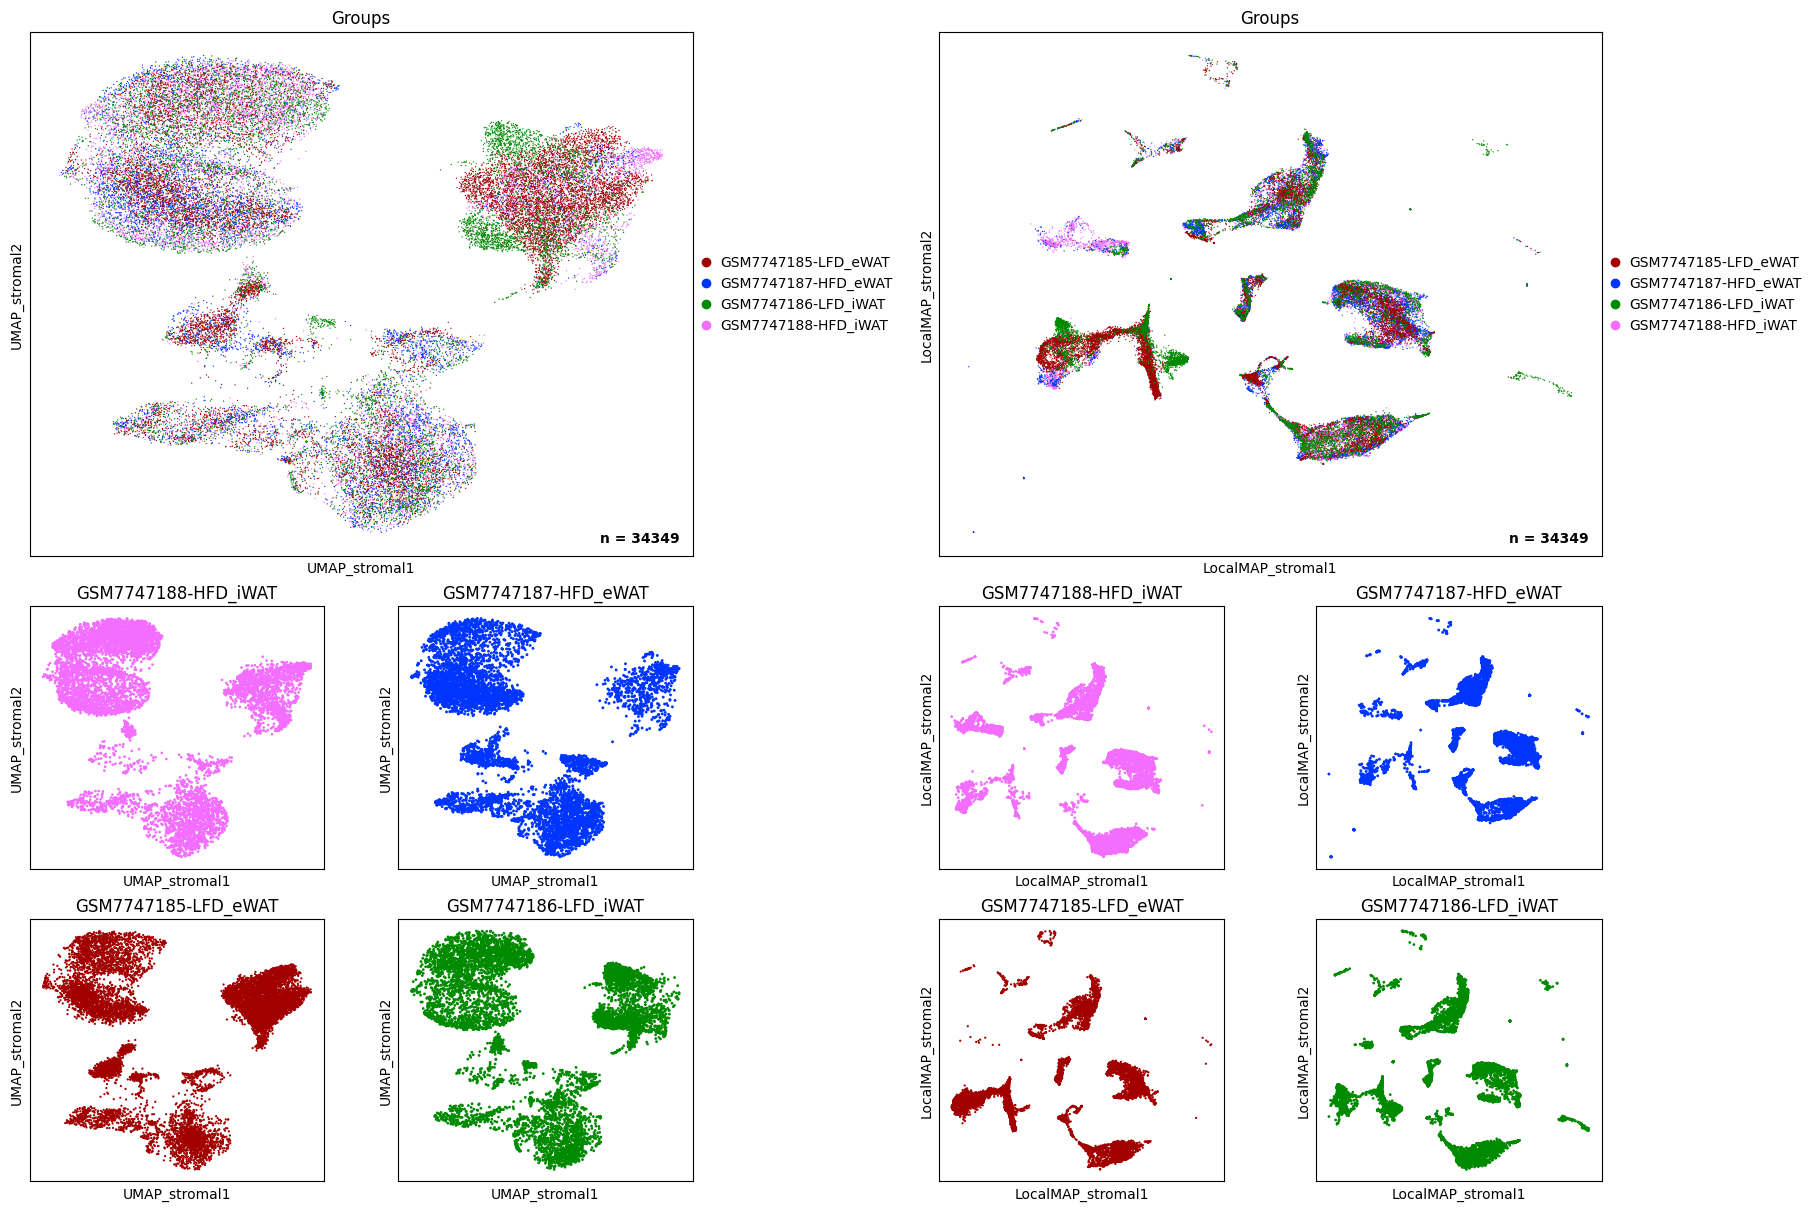

In [133]:
f = plt.figure(figsize=(18, 12), layout="constrained")
check_integration(
    adata_stromal,
    "Groups",
    f,
    embeddings=["UMAP_stromal", "LocalMAP_stromal"],
    nrow=2,
    ncol=2,
)

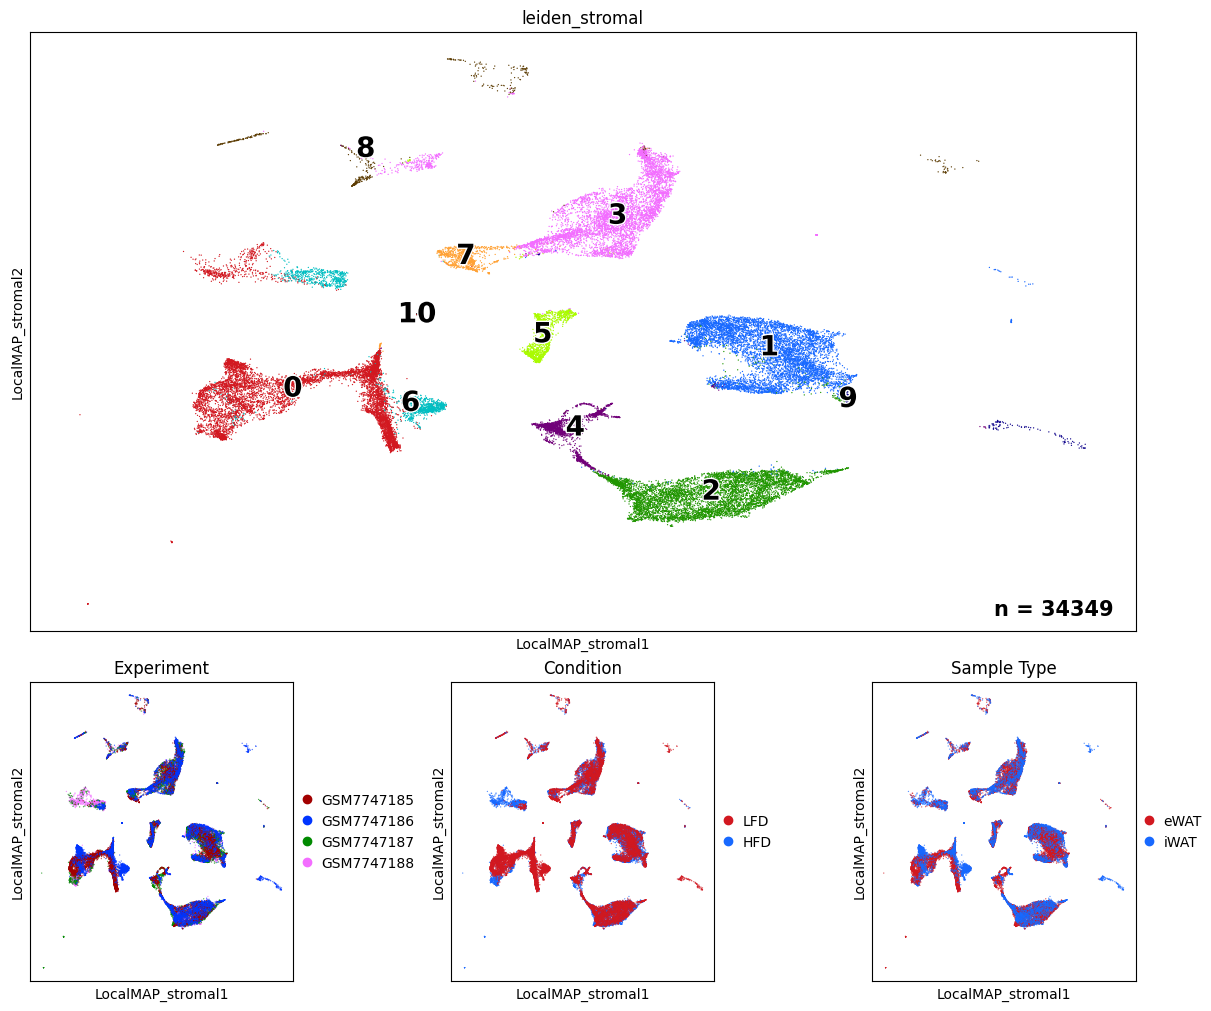

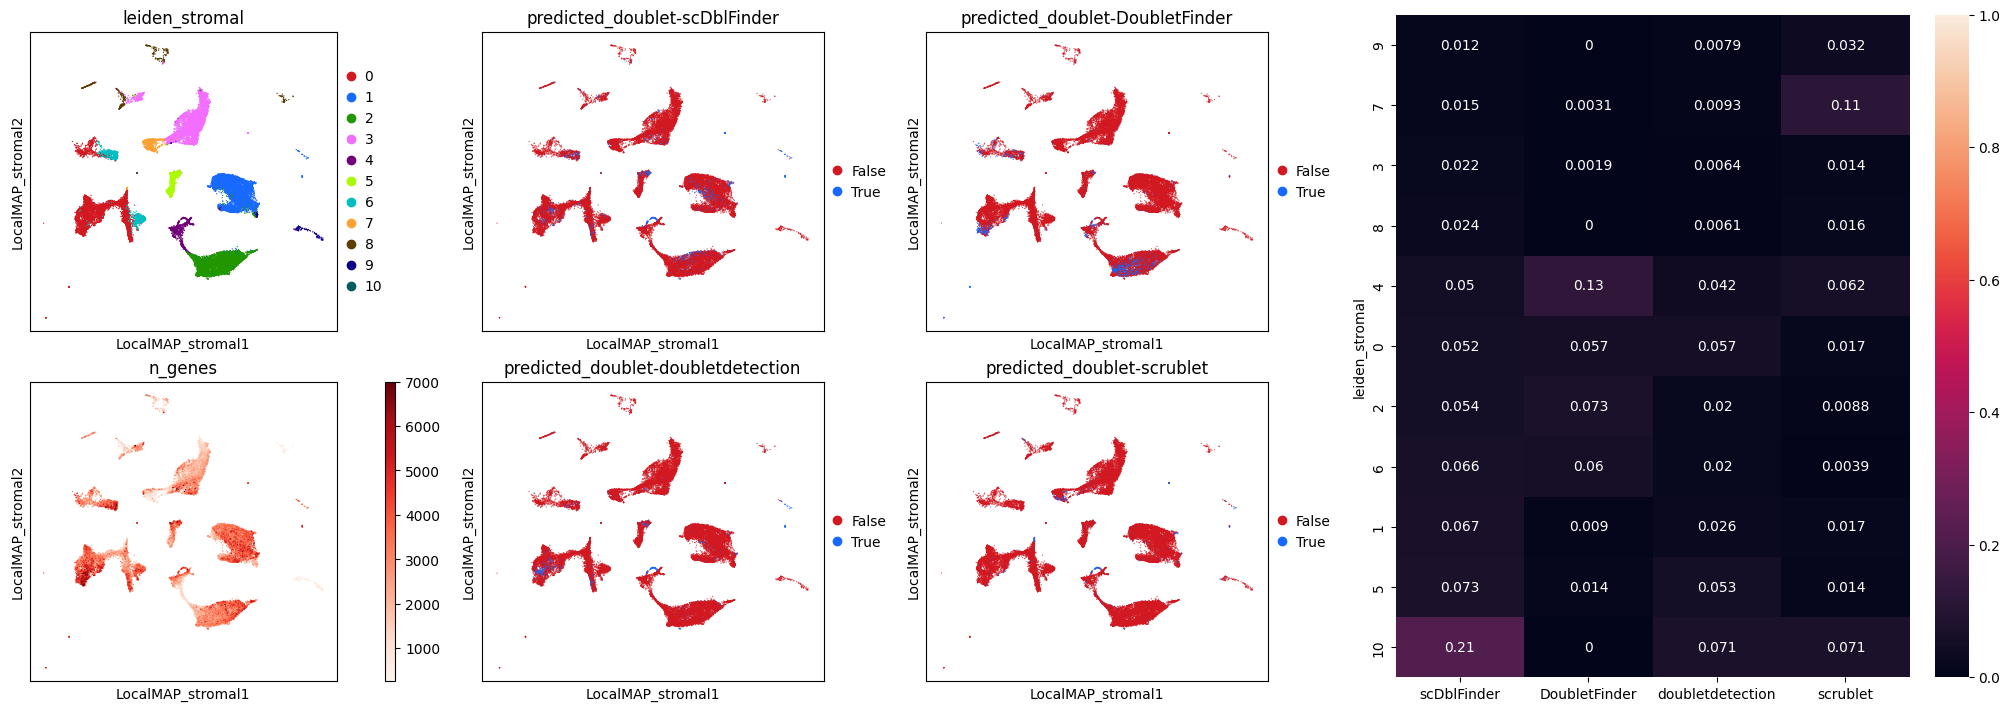

In [135]:
cluster = True
key = "leiden_stromal"
embedding = "LocalMAP_stromal"

# clsuter
if cluster is True:
    sc.tl.leiden(adata_stromal, resolution=0.5, key_added=key)

# figure prep
cluster_c = color_gen(adata_stromal.obs[key])
f = plt.figure(figsize=(12, 10), layout="constrained")

# Large LocalMAP plot
axs = f.subplots(3, 3)
gs = axs[0, 0].get_gridspec()
empty_axs(axs)

ax = f.add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=[key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=color_gen(adata_stromal.obs[key]).to_list(),
)
ax.annotate(
    f"n = {adata_stromal.shape[0]}",
    size=15,
    fontweight="bold",
    xy=(0.98, 0.02),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="bottom",
)
ax = f.add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Experiment"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Experiment"]).to_list(),
)
ax = f.add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Condition"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Condition"]).to_list(),
)
ax = f.add_subplot(gs[2, 2])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Sample Type"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Sample Type"]).to_list(),
)

checkDoublets(adata_stromal, embedding=embedding, cluster_key=key)

leiden_stromal     0     1     2     3     4     5     6    7    8    9  10
cell_type                                                                  
Adipocyte       8178     0     0   304     0     6  1536  964    0    5  14
Fibroblast         0  6807  6664     0     4     0     0    0    0    0   0
Mesothelial        0     0     5     2  2082     1     0    5    0  247   0
Endothelial        0     0     0  5338     1    13     0    0  490    0   0
PC/SMC             0     0     0     1     0  1682     0    0    0    0   0

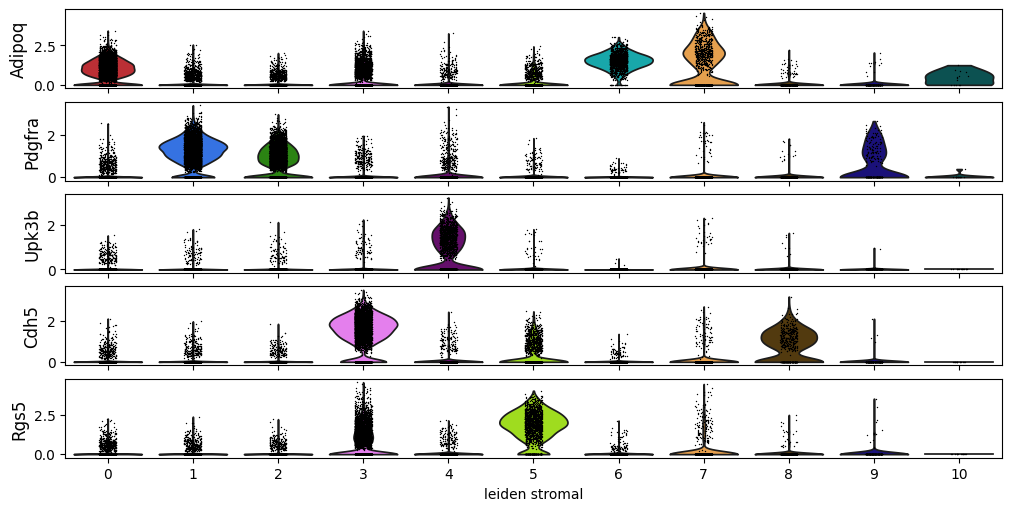

In [136]:
key = "leiden_stromal"

f = plt.figure(figsize=(10, 5), layout="constrained")
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5"]
plot_violinplot(adata_stromal, markers, key, f)
pd.crosstab(adata_stromal.obs["cell_type"], adata_stromal.obs[key])

Text(0.98, 0.02, 'n = 33366')

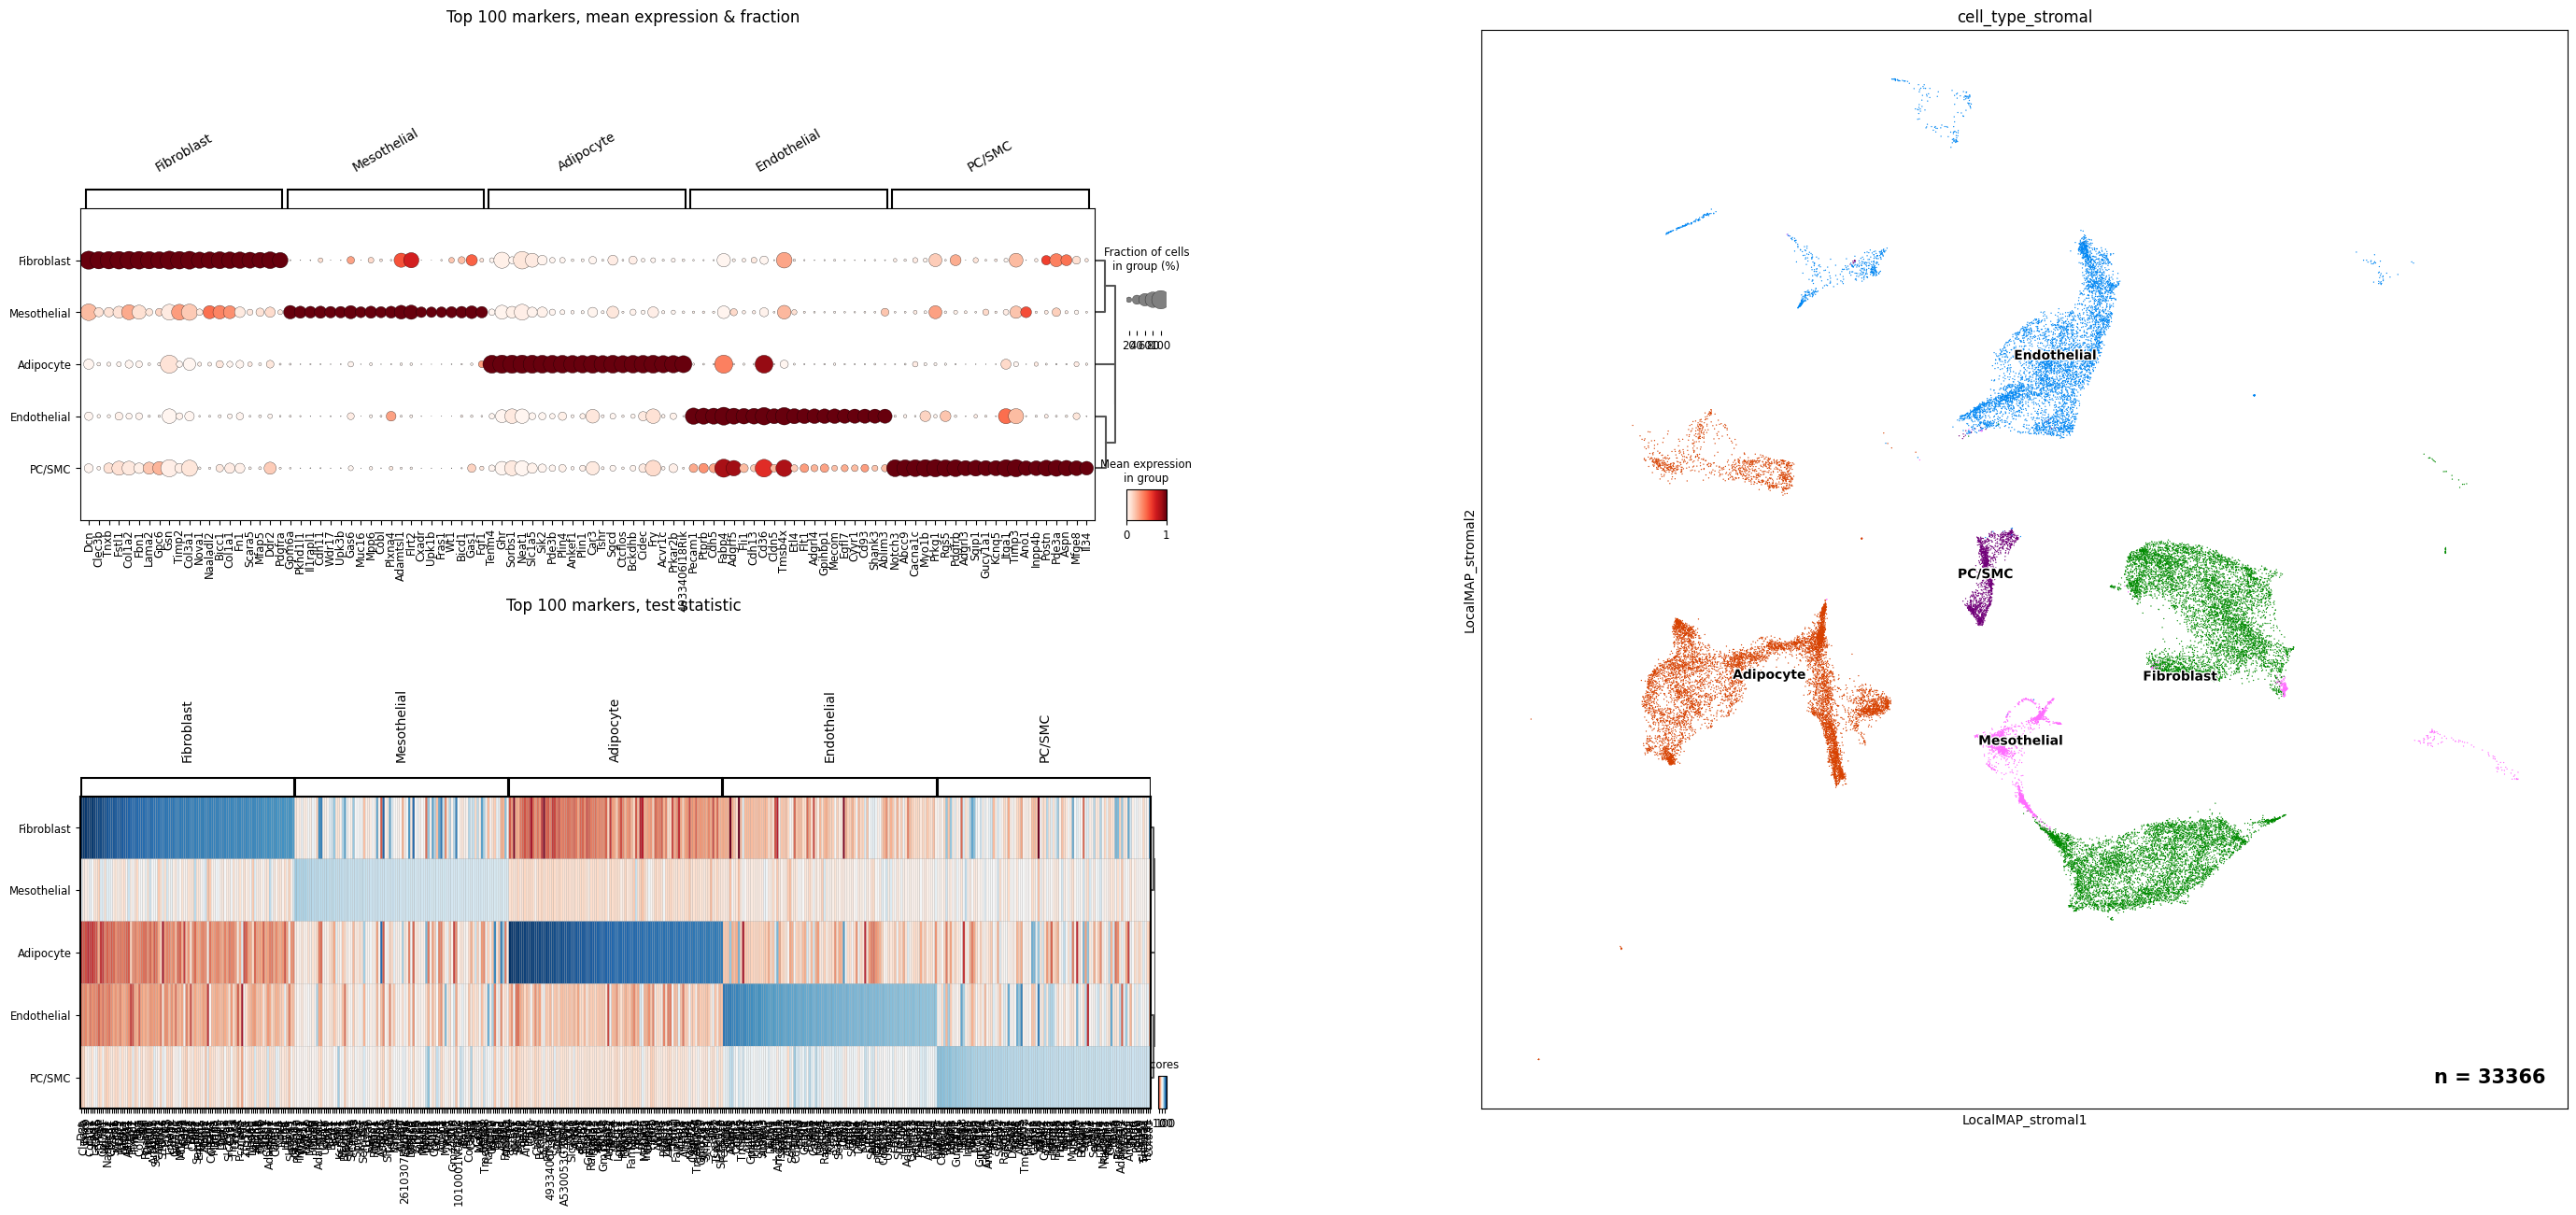

In [137]:
runDEGs = True
obs_key = "cell_type_stromal"
de_key = "de_stromal"

adata_stromal.obs[obs_key] = (
    adata_stromal.obs["leiden_stromal"]
    .astype(int)
    .map(
        {
            0: "Adipocyte",
            1: "Fibroblast",
            2: "Fibroblast",
            3: "Endothelial",
            4: "Mesothelial",
            5: "PC/SMC",
            6: "Adipocyte",
            7: "remove",
            8: "Endothelial",
            9: "Mesothelial",
            10: "remove",
        }
    )
    .astype("category")
)

adata_stromal = adata_stromal[adata_stromal.obs[obs_key] != "remove"]

if runDEGs is True:
    sc.tl.rank_genes_groups(
        adata_stromal,
        groupby=obs_key,
        use_raw=False,
        layer="normalized",
        key_added=de_key,
        method="wilcoxon",
    )

f = plt.figure(figsize=(30, 15), layout="constrained")

n_degs = 20
sf = f.subfigures(1, 2, width_ratios=[1, 1])
axs = sf[0].subplots(2, 1)
sc.pl.rank_genes_groups_dotplot(
    adata_stromal,
    groups=None,
    groupby=obs_key,
    key=de_key,
    standard_scale="var",
    n_genes=n_degs,
    var_group_rotation=30,
    ax=axs[0],
    show=False,
)

n_degs = 100
axs[0].set_title(f"Top {n_degs} markers, mean expression & fraction")
sc.pl.rank_genes_groups_matrixplot(
    adata_stromal,
    groups=None,
    groupby=obs_key,
    key=de_key,
    layer="normalized",
    use_raw=False,
    values_to_plot="scores",
    n_genes=n_degs,
    ax=axs[1],
    cmap="RdBu",
    vcenter=0,
    show=False,
)
axs[1].set_title(f"Top {n_degs} markers, test statistic")
axs[1].xaxis.set_visible(False)

ax = sf[1].subplots(1, 1)
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=[obs_key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=10,
    palette=color_gen(adata_stromal.obs[obs_key]).to_list(),
)
ax.annotate(
    f"n = {adata_stromal.shape[0]}",
    size=15,
    fontweight="bold",
    xy=(0.98, 0.02),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="bottom",
)

In [ ]:
de_key = "de_stromal"
df = sc.get.rank_genes_groups_df(adata_stromal, group=None, key=de_key)
stromal_markers = pd.concat(
    [
        genes[["group", "names", "scores", "logfoldchanges", "pvals_adj"]].head(100)
        for _, genes in df.groupby("group")
    ]
).reset_index(drop=True)
stromal_markers

group     names      scores  logfoldchanges      pvals_adj
0    Adipocyte     Tenm4  139.724625        6.224194   0.000000e+00
1    Adipocyte       Ghr  137.879364        4.158133   0.000000e+00
2    Adipocyte    Sorbs1  137.562744        4.412310   0.000000e+00
3    Adipocyte     Neat1  137.081406        2.977350   0.000000e+00
4    Adipocyte    Slc1a5  136.743942        3.638686   0.000000e+00
..         ...       ...         ...             ...            ...
495     PC/SMC     Lims1   30.807781        1.488041  3.531415e-206
496     PC/SMC   Slc12a2   30.644527        2.879737  5.267668e-204
497     PC/SMC  Tnfrsf21   30.642937        3.791299  5.486582e-204
498     PC/SMC   Tsc22d1   30.477070        1.840909  8.700652e-202
499     PC/SMC    Col6a3   29.809958        1.481798  4.627865e-193

[500 rows x 5 columns]

In [145]:
# save
annotation = "manDoublet-seuratV3-harmony-annotated_stromal_leiden0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
os.makedirs(savedir, exist_ok=True)
adata_stromal.write(os.path.join(savedir, f"{annotation}.h5ad"))

In [ ]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated_stromal_leiden0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
adata_stromal = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

# Save DEGs

In [146]:
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
stromal_markers.to_csv(
    os.path.join(savedir, "snRNA_SoEtAl2025_DEGS-stromal_markers.csv")
)
immune_markers.to_csv(os.path.join(savedir, "snRNA_SoEtAl2025_DEGS-immune_markers.csv"))
immuneVstromal_markers.to_csv(
    os.path.join(savedir, "snRNA_SoEtAl2025_DEGS-stromal_VS_immune_markers.csv")
)